In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom
import seaborn as sns

In [2]:
# Load cached data
!wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

2022-08-29 19:42:34 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "../data/imagenet/human_readable_labels.json" [1]


In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired selective accuracy
delta = 0.1 # delta is the failure rate
lambdas = np.linspace(0,1,5000)

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx,axis=1); val_yhats = np.argmax(val_smx,axis=1);
cal_phats = cal_smx.max(axis=1); val_phats = np.max(val_smx,axis=1);

In [5]:
# Define selective risk
def selective_risk(lam): return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): return (cal_phats >= lam).sum()
def invert_for_ub(r,lam): return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper boud
def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.9999,args=(lam,))
# Scan to choose lamabda hat
for lhat in np.flip(lambdas):
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
# Deploy procedure on test data
predictions_kept = val_phats >= lhat

In [6]:
# Calculate empirical selective accuracy
empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
print(f"The empirical selective accuracy is: {empirical_selective_accuracy}")
false_flags = (val_yhats[~predictions_kept] == val_labels[~predictions_kept]).mean()
print(f"The fraction of false flags is: {false_flags}")
fraction_kept = predictions_kept.mean()
print(f"The fraction of data points kept is: {fraction_kept}")

The empirical selective accuracy is: 0.9211404484514958
The fraction of false flags is: 0.46549400188704676
The fraction of data points kept is: 0.6971836734693878


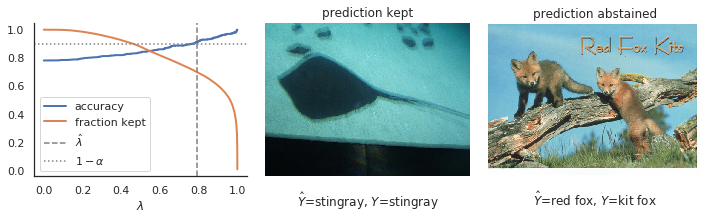

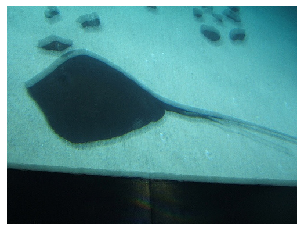

Prediction: stingray | Label: stingray | Abstained: False


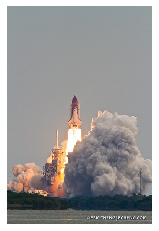

Prediction: space shuttle | Label: space shuttle | Abstained: False


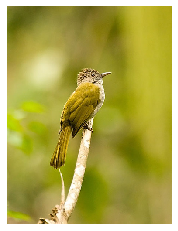

Prediction: bulbul | Label: bulbul | Abstained: True


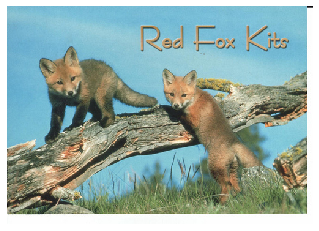

Prediction: red fox | Label: kit fox | Abstained: True


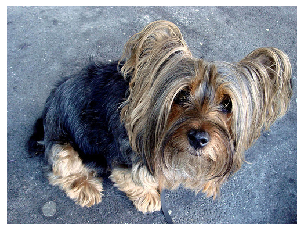

Prediction: Australian Silky Terrier | Label: Australian Silky Terrier | Abstained: False


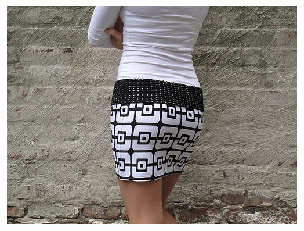

Prediction: miniskirt | Label: miniskirt | Abstained: True


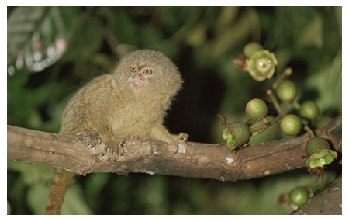

Prediction: marmoset | Label: marmoset | Abstained: False


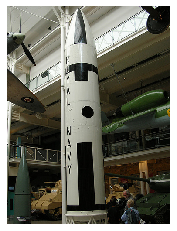

Prediction: missile | Label: projectile | Abstained: True


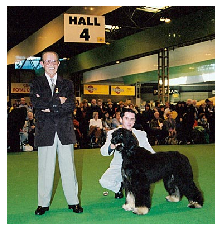

Prediction: Afghan Hound | Label: Afghan Hound | Abstained: False


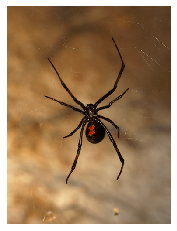

Prediction: southern black widow | Label: southern black widow | Abstained: False


In [7]:
# Get some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
_imgs = []
_keeps = []
_yhats = []
_labels = []
for i in range(10):
    rand_path = np.random.choice(example_paths)
    _imgs += [imread('../data/imagenet/examples/' + rand_path )]
    img_index = int(rand_path.split('.')[0])
    _keeps += [np.max(smx[img_index]) >= lhat]
    _yhats += [label_strings[np.argmax(smx[img_index])]]
    _labels += [label_strings[labels[img_index]]]        
_imgs = np.array(_imgs); _keeps = np.array(_keeps); _yhats = np.array(_yhats); _labels = np.array(_labels);

# Plot numerics and selected examples
sns.set(style='white')
selective_accuracy_curve = [1-selective_risk(lam) for lam in lambdas]
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs[0].plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs[0].axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs[0].axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs[0],top=True,right=True)
axs[0].legend(loc='lower left')
axs[0].set_xlabel(r'$\lambda$')
true_nonabstention_idx = np.argmax( (_yhats == _labels) & (_keeps))
axs[1].set_title('prediction kept')
axs[1].imshow(_imgs[true_nonabstention_idx])
axs[1].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_nonabstention_idx]}, ' + r'$Y$' + f'={_labels[true_nonabstention_idx]}')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
sns.despine(ax=axs[1],top=True,right=True,left=True,bottom=True)
true_abstention_idx = np.argmax( (_yhats != _labels) & (~_keeps))
axs[2].set_title('prediction abstained')
axs[2].imshow(_imgs[true_abstention_idx])
axs[2].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_abstention_idx]}, ' + r'$Y$' + f'={_labels[true_abstention_idx]}')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
sns.despine(ax=axs[2],top=True,right=True,left=True,bottom=True)
plt.tight_layout()
plt.savefig('../data/imagenet/selective-classification-results.pdf',dpi=60)
plt.show()
    
# Plot more examples
for i in range(len(_imgs)):
    plt.figure()
    plt.imshow(_imgs[i])
    plt.axis('off')
    plt.show()
    print(f"Prediction: {_yhats[i]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")